# Caffe on dogs and cats classification

By: 14331327 颜鹏翔 中山大学 软件工程(计应)

## 准备、caffe 安装
caffe 安装比较痛苦的一个地方就是依赖的安装，依赖安装好编译和后面问题其实都不难

1. 安装依赖（服务器已经安装好，所以不用安装了）
2. 下载caffe源代码：https://github.com/BVLC/caffe，使用git clone
3. 编译:  http://caffe.berkeleyvision.org/install_apt.html
4. 配置python接口(pycaffe)：http://caffe.berkeleyvision.org/tutorial/interfaces.html (python部分)
   参考：http://blog.csdn.net/u011762313/article/details/47624119

## 一、将数据转换为lmdb
训练集的数据是一系列的jpg文件，而caffe经常采用的是lmdb或leveldb格式的文件，所以先对数据集的图片进行转换。
具体转换可以参考：https://www.cnblogs.com/denny402/p/5082341.html

在该数据集上已经有人实现好了转换的脚本，在脚本中主要是对图片进行了预处理和格式的转换，这里我修改一下就可以直接使用在直接使用了：https://github.com/adilmoujahid/deeplearning-cats-dogs-tutorial/blob/master/code/create_lmdb.py

主要需要修改的地方有：
* 图片大小(根据pre-trained model的输入来设定)
* 数据集路径
* lmdb生成路径

如果是在ImageNet上进行训练的话，图片的大小就要resize为224\*224

In [3]:
import os
os.system('python ./deeplearning-cats-dogs-tutorial/code/create_lmdb.py')

0

In [4]:
ls ./input

train_lmdb/  validation_lmdb/


## 二、Fine-tune ResNet 50

### base model

* ResNet50 pre-trained model on ImageNet : https://github.com/KaimingHe/deep-residual-networks

* Paper: Kaiming He. Deep Residual Learning for Image Recognition. arXiv:1512.03385 [cs.CV]

### 定义模型：ResNet_train_val.prototxt

这里需要使用ImageNet的均值，pre-trained model要求的图片大小为224\*244

#### 添加全连接层、损失函数

修改读取数据，中间的层使用ResNet 50的网络，增加2维输出的全连接层，增加损失函数，增加层如下：
```
name: "ResNet_for_DC"
layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    mirror: true
    crop_size: 224
    mean_file: "/home/ypx/models/ResNet_mean.binaryproto"
  }
  data_param {
    source: "/home/ypx/input/train_lmdb"
    batch_size: 32
    backend: LMDB
  }
}
layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TEST
  }
  transform_param {
    mirror: false
    crop_size: 224
    mean_file: "/home/ypx/models/ResNet_mean.binaryproto"
  }
  data_param {
    source: "/home/ypx/input/validation_lmdb"
    batch_size: 32
    backend: LMDB
  }
}

# ... ResNet 50 base model

layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "fc1000-2"
  bottom: "label"
  top: "accuracy"
  include {
    phase: TEST
  }
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "fc1000-2"
  bottom: "label"
  top: "loss"
}


```

In [7]:
os.system('python /home/ypx/caffe-master/python/draw_net.py /home/ypx/models/ResNet_train_val.prototxt /home/ypx/doc/res50_dc.png')

0

模型图片部分截图：
![](https://ws1.sinaimg.cn/large/6177e8b1gy1fhhj12vjwwj2cn40dfe82.jpg)

![](https://ws1.sinaimg.cn/large/6177e8b1gy1fhh842w0fmj21x00s413a.jpg)
![](https://ws1.sinaimg.cn/large/6177e8b1gy1fhh84szv61j21rk0se0y5.jpg)


### 定义Solver：Solver.prototxt

Sovler主要是用来定义训练的相关参数(如迭代次数、优化器、学习速率、保存路径等）和所使用模型所在路径，定义如下：
```
net: "/home/ypx/models/caffe_models/ResNet_train_val.prototxt"
test_iter: 1000
test_interval: 1000
base_lr: 0.001
lr_policy: "step"
gamma: 0.1
stepsize: 2500
display: 50
max_iter: 20000
momentum: 0.9
weight_decay: 0.0005
snapshot: 5000
snapshot_prefix: "/home/ypx/models"
solver_mode: GPU
```
执行下面语句开始训练：
```
/home/ypx/caffe-master/build/tools/caffe train --solver /home/ypx/models/caffe_models/ResNet_train_val.prototxt --weights /home/ypx/models/ --gpu 1 2>&1 | tee /home/ypx/models/res50_train.log
```
其中：train指定该模式为训练模式，--solver 指定solver.prototxt位置，--weights 指定pre-trained model权值位置，log保存输出


### 绘制学习曲线

当训练到一个比较好的效果的时候，(稍微过拟合）的时候就可以终止训练，训练好的模型权重将保存在`.caffemodel`文件中。可以通过下面命令绘制出它的学习曲线：
```
python /home/ypx/deeplearning-cats-dogs-tutorial/code/plot_learning_curve.py /home/ypx/models/res50_train.log /home/ypx/doc/res50_curve.png
```
训练 5000次左右，测试集准确率0.99左右
```
I0712 18:25:02.563923   577 solver.cpp:397]     Test net output #0: accuracy = 0.990301
I0712 18:25:02.563971   577 solver.cpp:397]     Test net output #1: loss = 0.0262112 (* 1 = 0.0262112 loss)
```

![](https://ws1.sinaimg.cn/large/6177e8b1gy1fhhaqrsk6ej20hs0dcq41.jpg)

## 三、预测

这里直接随机从测试数据集中挑选几张图片进行预测，然后将图片和其预测的标签展示出来

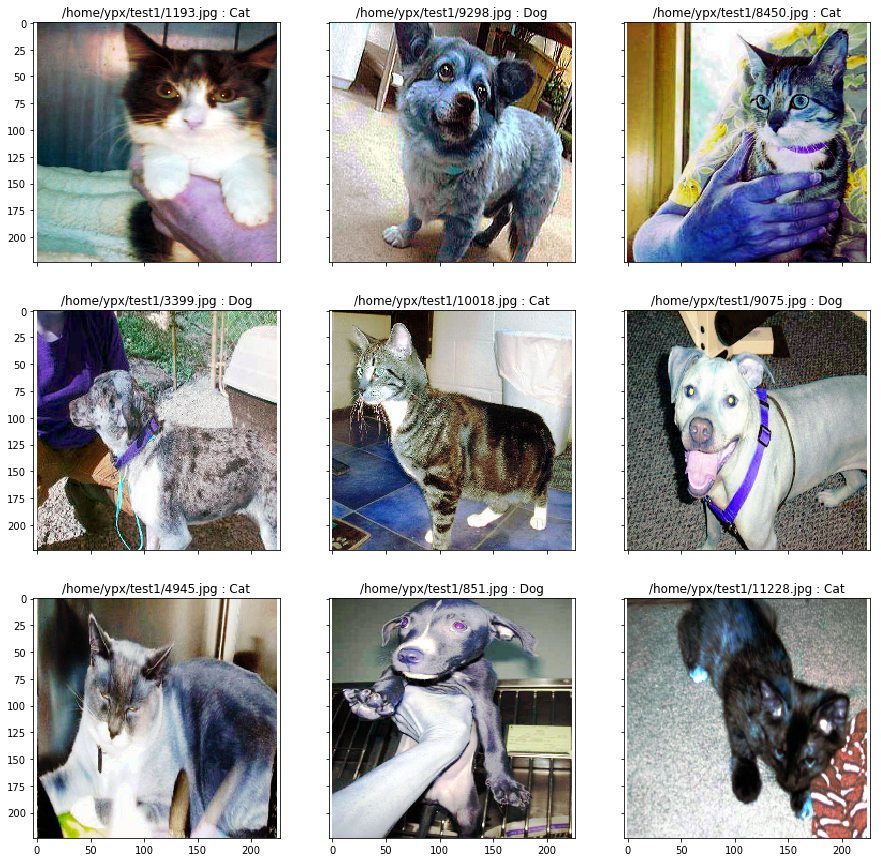

In [1]:
import os
import glob
import caffe
import lmdb
import numpy as np
from caffe.proto import caffe_pb2
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

caffe.set_mode_gpu() 

#Size of images
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

'''
Image processing helper function
'''

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


'''
Reading mean image, caffe model and its weights 
'''
#Read mean image
mean_blob = caffe_pb2.BlobProto()
with open('/home/ypx/models/ResNet_mean.binaryproto') as f:
    mean_blob.ParseFromString(f.read())
mean_array = np.asarray(mean_blob.data, dtype=np.float32).reshape(
    (mean_blob.channels, mean_blob.height, mean_blob.width))


#Read model architecture and trained model's weights
net = caffe.Net('/home/ypx/models/ResNet-50-deploy.prototxt',
                '/home/ypx/models_iter_5000.caffemodel',
                caffe.TEST)

#Define image transformers
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', mean_array)
transformer.set_transpose('data', (2,0,1))

'''
Making predicitions
'''
#Reading image paths
test_img_paths = [img_path for img_path in glob.glob("/home/ypx/test1/*jpg")]

#Making predictions
test_ids = []
preds = []

_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15, 15))

for i in range(9):
    rand = np.random.randint(0, len(test_img_paths))
    img_path = test_img_paths[rand]
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
    
    net.blobs['data'].data[...] = transformer.preprocess('data', img)
    out = net.forward()
    pred_probas = out['prob']

    test_ids = test_ids + [img_path.split('/')[-1][:-4]]
    preds = preds + [pred_probas.argmax()]
    
    result = ""
    if pred_probas.argmax() == 1:
        result = "Dog"
    else:
        result = "Cat"
    ax[i // 3, i % 3].imshow(img)
    ax[i // 3, i % 3].set_title(img_path + ' : ' + result)

plt.show()


## 四、参考

* Kaiming He. Deep Residual Learning for Image Recognition. arXiv:1512.03385 [cs.CV]
* [KaimingHe: ResNet on caffe](https://github.com/KaimingHe/deep-residual-networks)
* [A Practical Introduction to Deep Learning with Caffe and Python](http://adilmoujahid.com/posts/2016/06/introduction-deep-learning-python-caffe/)
* [caffe](http://caffe.berkeleyvision.org)
